# Retail Analytics
Demo of Various OLAP Operations via EDA on Retail Analytics Dataset

## This notebook is divided into three parts
- Exploratory data analysis
- Сategorical data analysis
- Time series forecasting with Fbprophet (In-Sample and Out-Sample Forecast, forecast with and without regressors)

In [1]:
#Importing all the necessary libraies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns


import datetime as dt


import sklearn
from sklearn.model_selection import train_test_split
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


import fbprophet
from fbprophet import Prophet

from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import performance_metrics

from fbprophet.plot import add_changepoints_to_plot

In [2]:
# Import data and parse date columns

stores=pd.read_csv('../stores data-set.csv')
features=pd.read_csv('../Features data set.csv', parse_dates=['Date'])
sales=pd.read_csv('../sales data-set.csv', parse_dates=['Date'])

## 1 - Exploratory Data Analysis (EDA)

### Table features
Additional data related to the store, department and regional activity for the given dates.

In [3]:
features.head(2)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True


In [4]:
features.shape

(8190, 12)

In [5]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     4032 non-null   float64       
 5   MarkDown2     2921 non-null   float64       
 6   MarkDown3     3613 non-null   float64       
 7   MarkDown4     3464 non-null   float64       
 8   MarkDown5     4050 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 712.0 KB


In [6]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


### Table stores
Anonymized information about the 45 stores, indicating the type and size of store

In [7]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [8]:
stores.shape

(45, 3)

In [9]:
#Number of stores
stores.Store.nunique()

45

In [10]:
# Types of stores
stores['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

### Table sales
Historical sales data

In [11]:
sales.tail(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


In [12]:
sales.shape

(421570, 5)

In [13]:
# Date unique values
sales['Date'].nunique()

143

In [14]:
# Holiday weeks

sales_weekly = sales.groupby(['Date', 'IsHoliday'], as_index = False).agg({'Weekly_Sales':"sum"})

In [15]:
sales_weekly['IsHoliday'].value_counts()

False    133
True      10
Name: IsHoliday, dtype: int64

In [16]:
# Total sales for 3 years
sales['Weekly_Sales'].sum()


6737218987.11

### Check for missing values (NaN)

In [17]:
#check for nan values in features
features.isna().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

<AxesSubplot:>

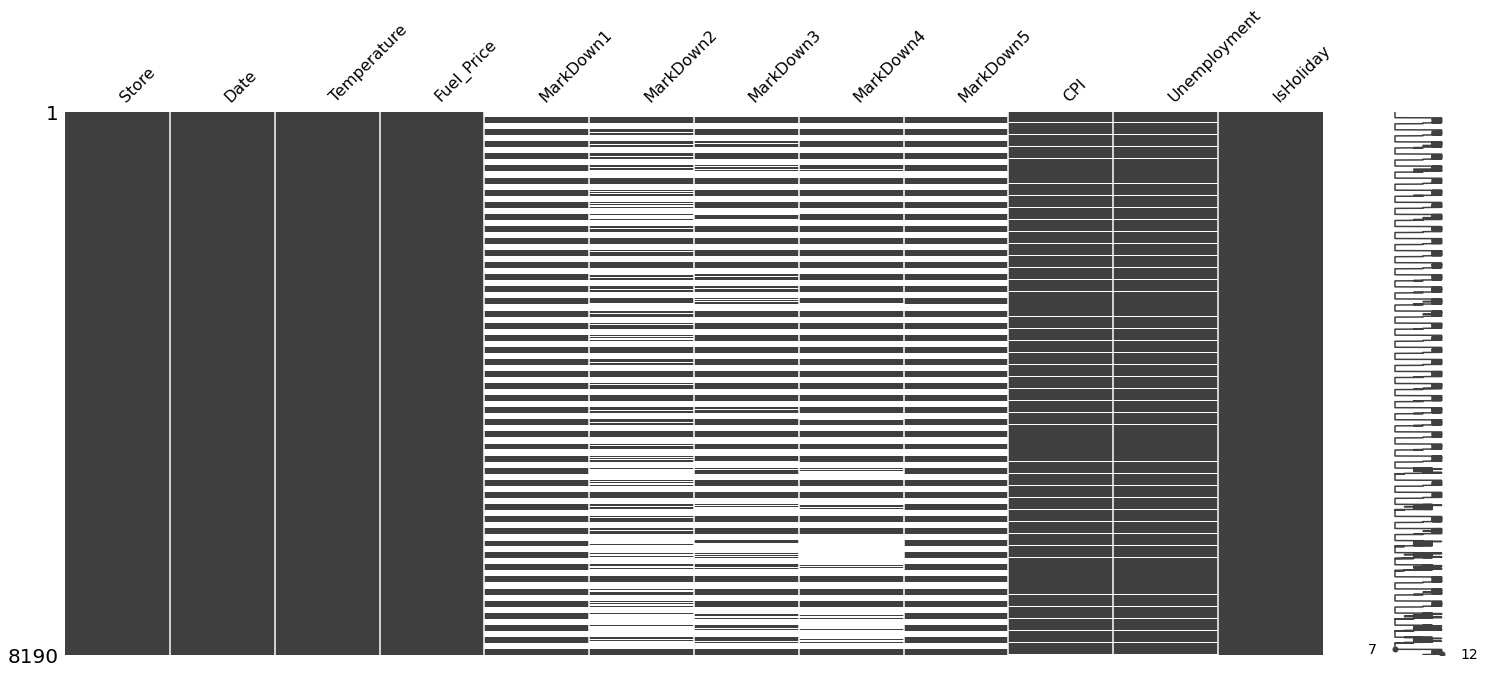

In [18]:
#Visualize missing values (NaN) with Missingno Library in features
msno.matrix(features)

In [19]:
#Check for NaN in sales
sales.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [20]:
#Check for NaN in stores
stores.isna().sum()

Store    0
Type     0
Size     0
dtype: int64

# Data Pre-Processing
### Merge the information of 3 tables (sales, features, stores) into one dataframe df

In [21]:
df=pd.merge(sales,features, on=['Store','Date', 'IsHoliday'], how='left')

df=pd.merge(df,stores, on=['Store'], how='left')

In [22]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-05-02,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-12-02,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-05-03,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [23]:
# df structure
df.shape

(421570, 16)

In [24]:
# check total sales after joining
df['Weekly_Sales'].sum()

6737218987.11

In [25]:
#check for missing values

df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

In [26]:
#check for duplicates

df.duplicated().sum()

0

### Drop MarkDown columns from analysis

In [27]:
df = df.drop(columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5', 'Size'],axis = 1)

In [28]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type
0,1,1,2010-05-02,24924.50,False,42.31,2.572,211.096358,8.106,A
1,1,1,2010-12-02,46039.49,True,38.51,2.548,211.242170,8.106,A
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A
4,1,1,2010-05-03,21827.90,False,46.50,2.625,211.350143,8.106,A


In [29]:
#temperature unit conversion
df['Temperature'] = (df['Temperature']- 32) * 5./9.

#factorize (Yes/No to 1/0 conversion)
holidays_factor, types =df['IsHoliday'].factorize()
df['IsHoliday'] = holidays_factor

df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type
0,1,1,2010-05-02,24924.50,0,5.727778,2.572,211.096358,8.106,A
1,1,1,2010-12-02,46039.49,1,3.616667,2.548,211.242170,8.106,A
2,1,1,2010-02-19,41595.55,0,4.405556,2.514,211.289143,8.106,A
3,1,1,2010-02-26,19403.54,0,8.127778,2.561,211.319643,8.106,A
4,1,1,2010-05-03,21827.90,0,8.055556,2.625,211.350143,8.106,A


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  int64         
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   CPI           421570 non-null  float64       
 8   Unemployment  421570 non-null  float64       
 9   Type          421570 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 35.4+ MB


### Generate descriptive statistics on df 

In [31]:
df.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,0.070358,15.605588,3.361027,171.201947,7.960289
std,12.785297,30.492054,22711.183519,0.255750,10.248851,0.458515,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,0.000000,-18.922222,2.472000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,0.000000,8.155556,2.933000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,0.000000,16.716667,3.452000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,0.000000,23.488889,3.738000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,1.000000,37.855556,4.468000,227.232807,14.313000


For further analysis, let's add the columns of the year, month, date of year and week number

In [32]:
df['Y'] = df['Date'].dt.year

In [33]:
df['M'] = df['Date'].dt.month

In [34]:
df['D'] = df['Date'].dt.dayofyear

In [35]:
df['W'] = df['Date'].dt.weekofyear

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [36]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Y,M,D,W
0,1,1,2010-05-02,24924.50,0,5.727778,2.572,211.096358,8.106,A,2010,5,122,17
1,1,1,2010-12-02,46039.49,1,3.616667,2.548,211.242170,8.106,A,2010,12,336,48
2,1,1,2010-02-19,41595.55,0,4.405556,2.514,211.289143,8.106,A,2010,2,50,7
3,1,1,2010-02-26,19403.54,0,8.127778,2.561,211.319643,8.106,A,2010,2,57,8
4,1,1,2010-05-03,21827.90,0,8.055556,2.625,211.350143,8.106,A,2010,5,123,18


In [37]:
# There are 52 Weeks in a year 
df['W'].nunique()

52

In [38]:
# There are 12 Months in a year 
df['M'].nunique()

12

# 2 - Сategorical data analysis

Sales analysis by dates, different types of stores and conditions

Plot weekly sales sums

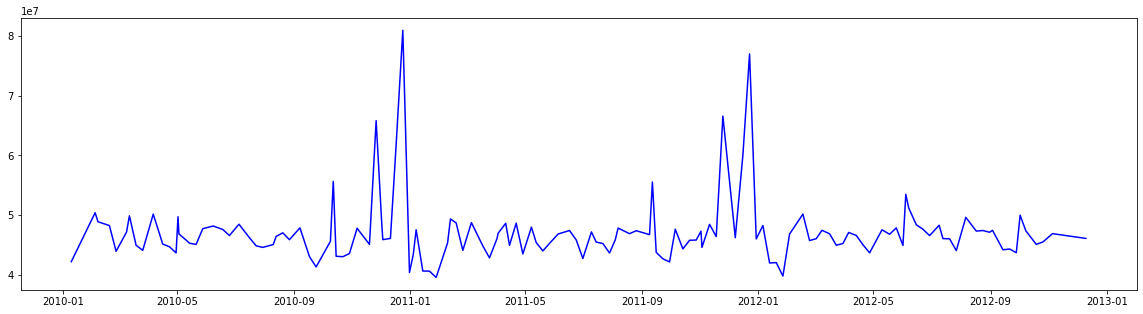

In [39]:
df_average_sales_weekly = df.groupby('Date', as_index=False)\
    .agg({'Weekly_Sales': 'sum'})

df_average_sales_sorted = df_average_sales_weekly.sort_values('Weekly_Sales', ascending = False)

plt.figure(figsize=(20,5))

plt.plot(df_average_sales_weekly.Date, df_average_sales_weekly.Weekly_Sales, color = 'b')

plt.show()

Plot weekly sales mean by months

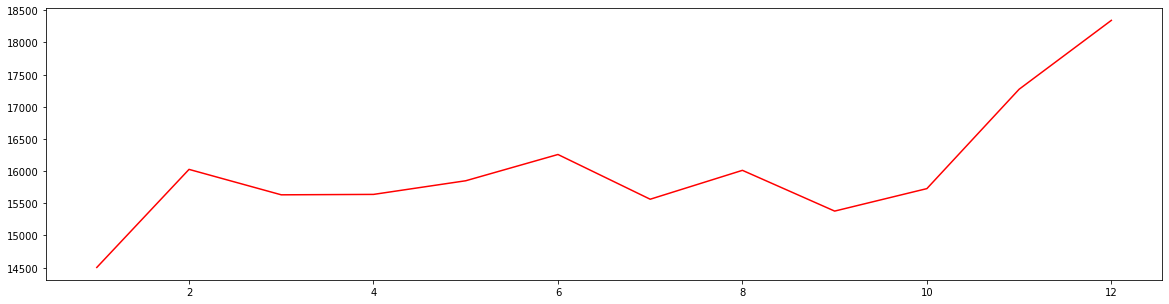

In [40]:
df_average_sales_monthly = df.groupby('M', as_index=False)\
    .agg({'Weekly_Sales': 'mean'})
plt.figure(figsize=(20,5))
plt.plot(df_average_sales_monthly.M, df_average_sales_monthly.Weekly_Sales, color = 'r')
plt.show()

In [41]:
# Most profitable weeks
df_average_sales_sorted.head()

,Date,Weekly_Sales
46,2010-12-24,80931415.60
98,2011-12-23,76998241.31
95,2011-11-25,66593605.26
41,2010-11-26,65821003.24
45,2010-12-17,61820799.85


In [42]:
# Compare weekly sales by years

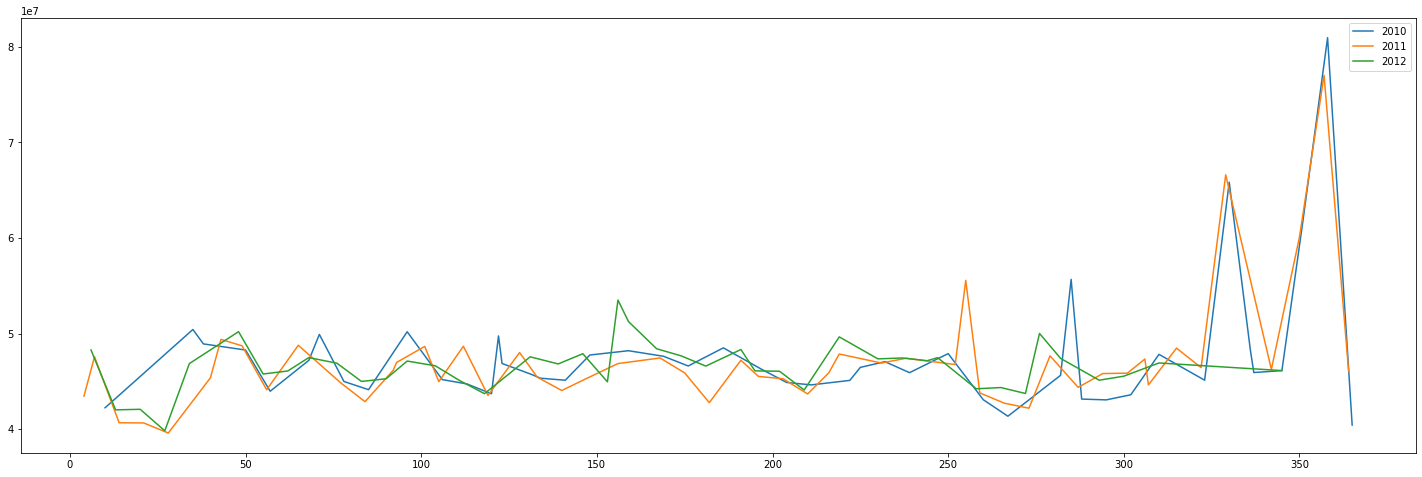

In [43]:
df10 = df.query('Y == 2010').groupby('D', as_index=False)\
    .agg({'Weekly_Sales': 'sum'})
df11 = df.query('Y == 2011').groupby('D', as_index=False)\
    .agg({'Weekly_Sales': 'sum'})
df12 = df.query('Y == 2012').groupby('D', as_index=False)\
    .agg({'Weekly_Sales': 'sum'})
fig, ax = plt.subplots(figsize=(25,8))
ax.plot(df10.D, df10.Weekly_Sales, label = "2010")
ax.plot(df11.D, df11.Weekly_Sales, label = "2011")
ax.plot(df12.D, df12.Weekly_Sales, label = "2012")
ax.legend()
plt.show()

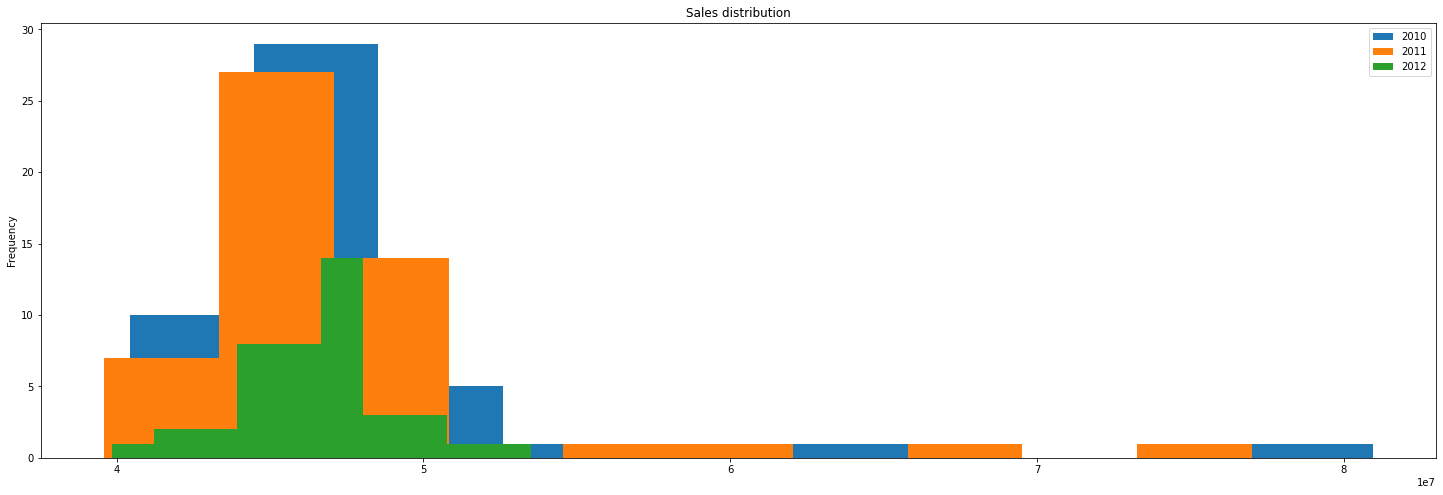

In [44]:
# Sales sums distribution

fig, ax = plt.subplots(figsize=(25,8))

df10['Weekly_Sales'].plot(kind='hist', title='Sales distribution', label = "2010");

df11['Weekly_Sales'].plot(kind='hist', label = "2011");
df12['Weekly_Sales'].plot(kind='hist', label = "2012");

ax.legend()
plt.show()

2012 sales do not have significant positive emissions like in 2010 and 2011 because of lack of data on 2012 december holidays weeks

In [45]:
df_average_sales_weekly['Date'].tail(5)

138   2012-10-08
139   2012-10-19
140   2012-10-26
141   2012-11-05
142   2012-12-10
Name: Date, dtype: datetime64[ns]

In [46]:
# Rolling mean (window = 4)

In [47]:
df_average_sales_weekly['rol_month'] = df_average_sales_weekly['Weekly_Sales'].rolling(4).mean()

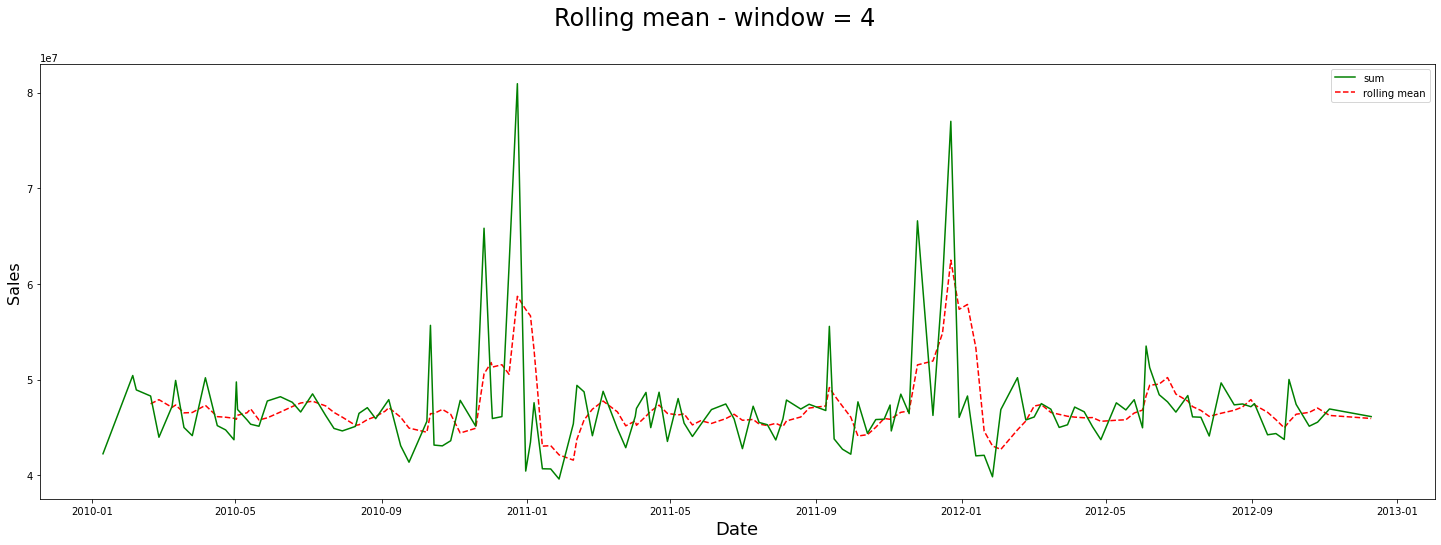

In [48]:
fig = plt.figure(figsize=(25,8))
line1, = plt.plot(df_average_sales_weekly.Date, df_average_sales_weekly.rol_month, '--', color='red')
line2, = plt.plot(df_average_sales_weekly.Date, df_average_sales_weekly.Weekly_Sales,  color='green')

fig.suptitle('Rolling mean - window = 4', fontsize=24)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Sales', fontsize=16)

plt.legend((line2, line1), ['sum', 'rolling mean'])



plt.show()

The most profitable weeks and months coincide with the holidays of Christmas and Thanksgiving

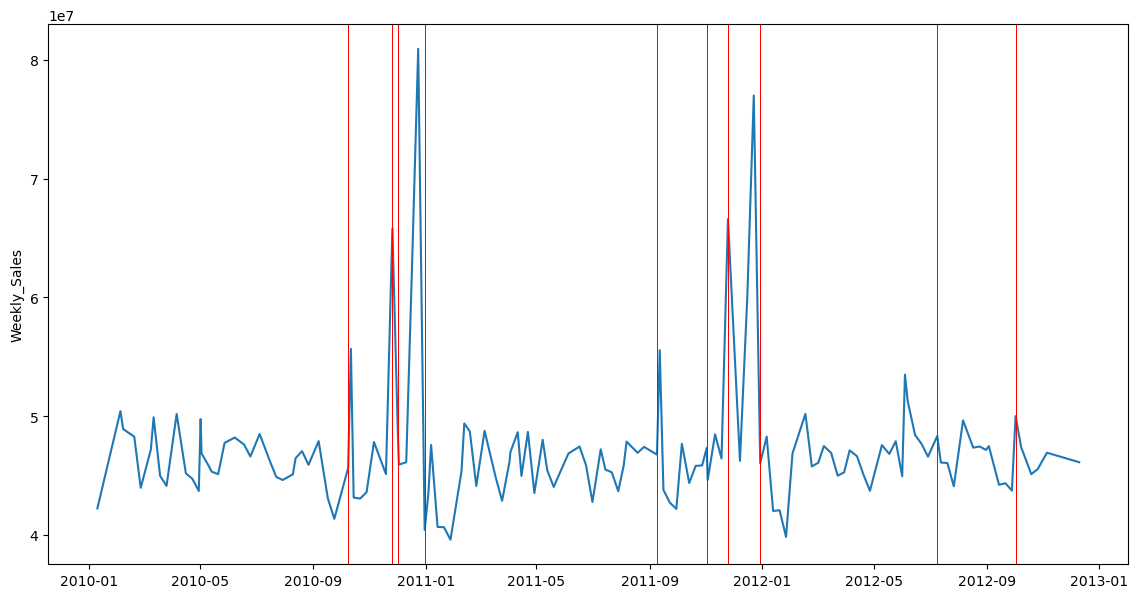

In [49]:
# holiday weeks are marked with red lines
df2=df.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
f_1 = plt.figure(figsize=(12,6), dpi=100)
ax_1 = f_1.add_axes([0.0, 0.0, 0.9, 0.9])
ax_1.set_ylabel('Weekly_Sales')
ax_1.plot(df2['Date'], df2['Weekly_Sales'])

for x in df[df['IsHoliday']==1]['Date']:
    ax_1.axvline(x=x, color='red', linewidth=0.5)

Difference of Weekly Sales sum by day of year compared with a previous day of year

In [50]:
df_SW = df.groupby('D', as_index=False)\
    .agg({'Weekly_Sales': 'sum'})

df_SW['differ'] = df_SW['Weekly_Sales'].diff()

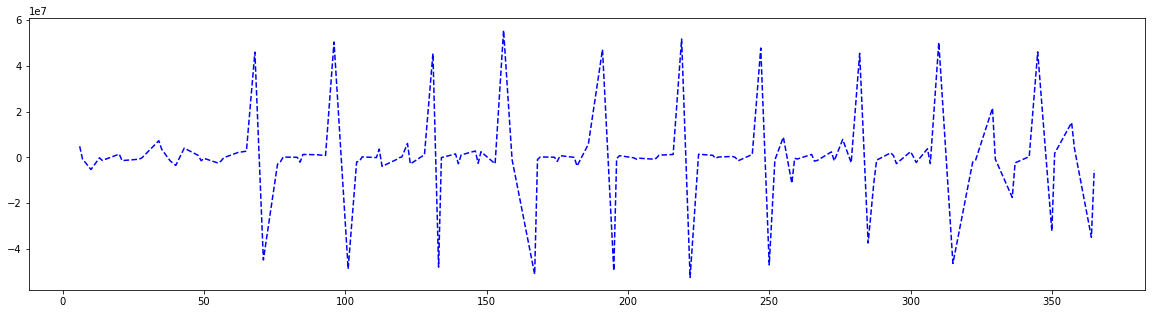

In [51]:
plt.figure(figsize=(20,5))
plt.plot(df_SW.D, df_SW.differ, '--', color = 'b')
plt.show()

Difference of Weekly Sales sum by date compared with a previous date

In [52]:
df_SW2 = df.groupby('Date', as_index=False)\
    .agg({'Weekly_Sales': 'sum'})

df_SW2['differ'] = df_SW2['Weekly_Sales'].diff()

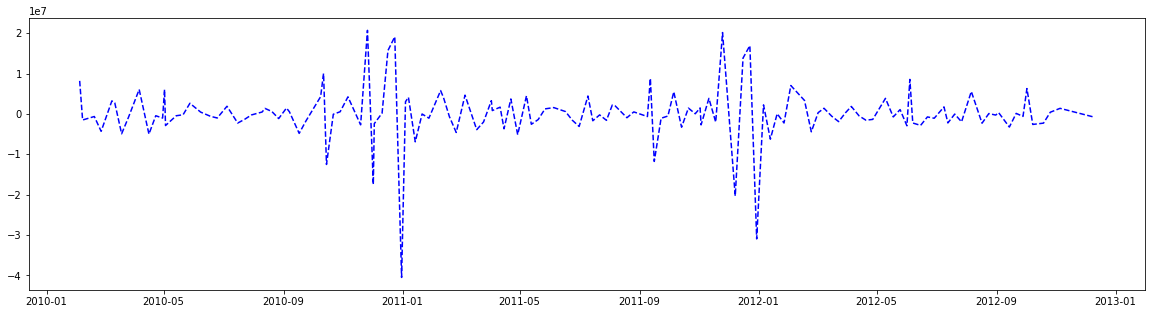

In [53]:
plt.figure(figsize=(20,5))
plt.plot(df_SW2.Date, df_SW2.differ, '--', color = 'b')
plt.show()

### Sales analysis by store types

In [54]:
df_type = df.groupby('Type', as_index=False).agg(Mean=('Weekly_Sales', 'mean'), Sum=('Weekly_Sales', 'sum'))
df_type

,Type,Mean,Sum
0,A,20099.568043,4.331015e+09
1,B,12237.075977,2.000701e+09
2,C,9519.532538,4.055035e+08


Text(0.5, 1.0, 'Mean weekly sales by years')

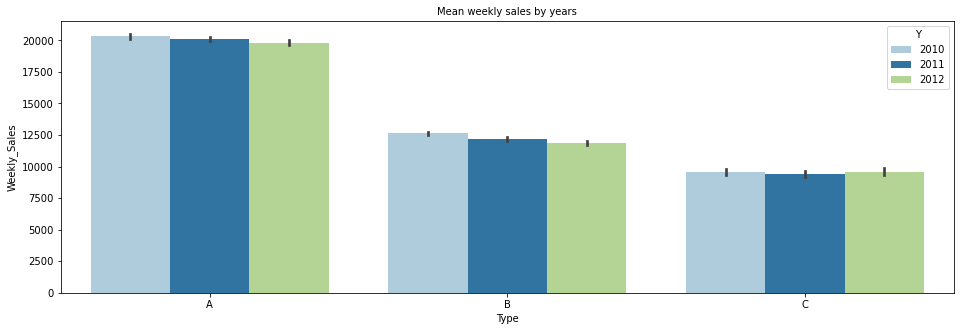

In [55]:
plt.figure(figsize = (16,5))
ax = sns.barplot(x="Type", y="Weekly_Sales", hue="Y", data=df, palette= "Paired")
ax.set_title('Mean weekly sales by years',fontsize=10)

In [56]:
df_gr_type = df.groupby('Type', as_index = False)\
    .agg({'Weekly_Sales':'mean'})\
    .sort_values('Weekly_Sales', ascending = False)

In [57]:
df_gr_type

,Type,Weekly_Sales
0,A,20099.568043
1,B,12237.075977
2,C,9519.532538


Top-5 stores by sales

In [58]:
df_gr = df.groupby('Store', as_index = False)\
    .agg({'Weekly_Sales':'sum'})\
    .sort_values('Weekly_Sales', ascending = False)

In [59]:
df_gr.head(5)

,Store,Weekly_Sales
19,20,3.013978e+08
3,4,2.995440e+08
13,14,2.889999e+08
12,13,2.865177e+08
1,2,2.753824e+08


### Unemployment analysis

In [60]:
df_gr_u = df.groupby('Y', as_index = False)\
    .agg({'Unemployment':'mean'})\
    .sort_values('Unemployment', ascending = False)

In [61]:
df_gr_u

,Y,Unemployment
0,2010,8.446427
1,2011,8.036353
2,2012,7.332047


### The consumer price index


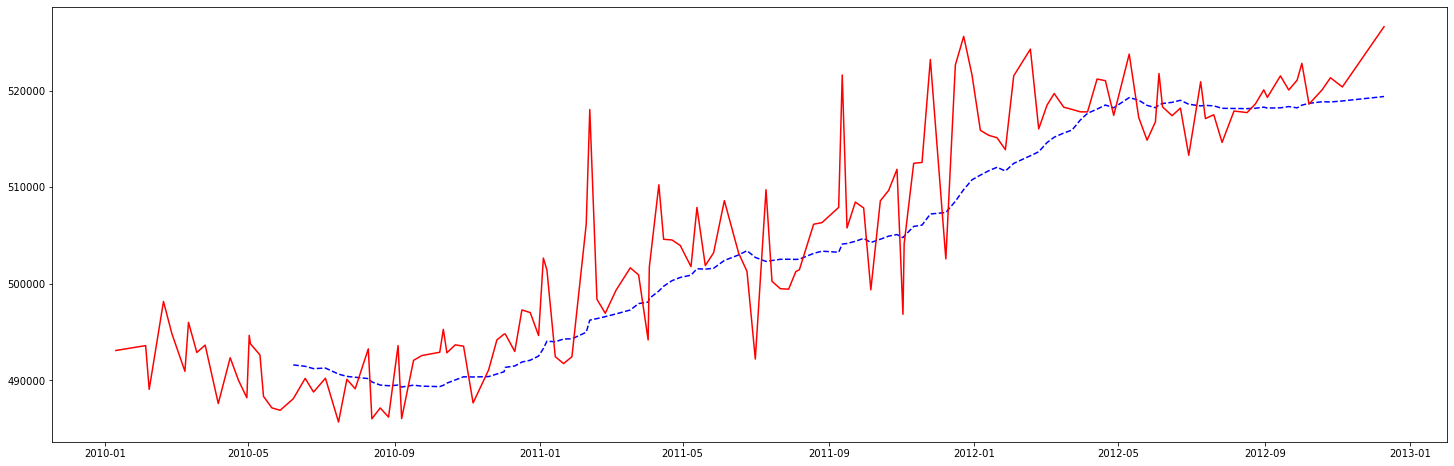

In [62]:
fig = plt.figure(figsize=(25,8))
df_average_sales_weekly2 = df.groupby('Date', as_index=False)\
    .agg({'CPI': 'sum'})
df_average_sales_sorted = df_average_sales_weekly2.sort_values('CPI', ascending = False)


df_average_sales_weekly2['rol_month'] = df_average_sales_weekly2['CPI'].rolling(20).mean()
line1 = plt.plot(df_average_sales_weekly2.Date, df_average_sales_weekly2.rol_month, '--', color='b')


plt.plot(df_average_sales_weekly2.Date, df_average_sales_weekly2.CPI, color = 'r')
plt.show()

In [63]:
df_gr_cpi = df.groupby('Y', as_index = False)\
    .agg({'CPI':'mean'})\
    .sort_values('CPI', ascending = False)

In [64]:
df_gr_cpi

,Y,CPI
2,2012,175.061958
1,2011,171.181195
0,2010,167.727885


### Fuel Price tendency

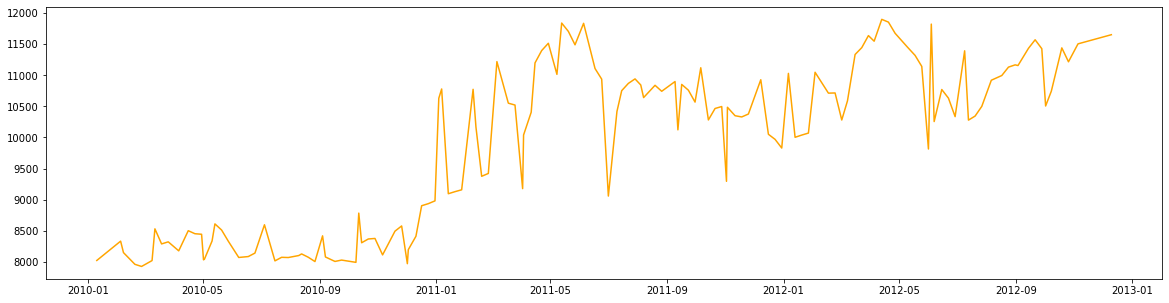

In [65]:
df_average_sales_weekly2 = df.groupby('Date', as_index=False)\
    .agg({'Fuel_Price': 'sum'})
df_average_sales_sorted = df_average_sales_weekly2.sort_values('Fuel_Price', ascending = False)

plt.figure(figsize=(20,5))
plt.plot(df_average_sales_weekly2.Date, df_average_sales_weekly2.Fuel_Price, color = 'orange')
plt.show()

### Temperature analysis

In [66]:
df.shape

(421570, 14)

In [67]:
labels=["less than -10 deg", "-10-0", "0-10", "10-15", "15-20", "20-25", "more than 25"]
bins=[-np.inf,-10,0,10,15,20,25, np.inf]
df['temperature_category'] = pd.cut(df['Temperature'], bins=bins, labels=labels,right=False) 

In [68]:
df_gr_t = df.groupby('temperature_category', as_index = False)\
    .agg({'Weekly_Sales':'sum'})\
    .sort_values('Weekly_Sales', ascending = False)

In [69]:
df_gr_t

,temperature_category,Weekly_Sales
2,0-10,1.492362e+09
6,more than 25,1.331199e+09
5,20-25,1.268579e+09
4,15-20,1.100358e+09
3,10-15,1.003497e+09
1,-10-0,5.255594e+08
0,less than -10 deg,1.566314e+07


In [70]:
data_tab = df['temperature_category'].value_counts()

In [71]:
data_tab

0-10                 90626
more than 25         85134
20-25                78108
15-20                69267
10-15                62932
-10-0                34067
less than -10 deg     1436
Name: temperature_category, dtype: int64

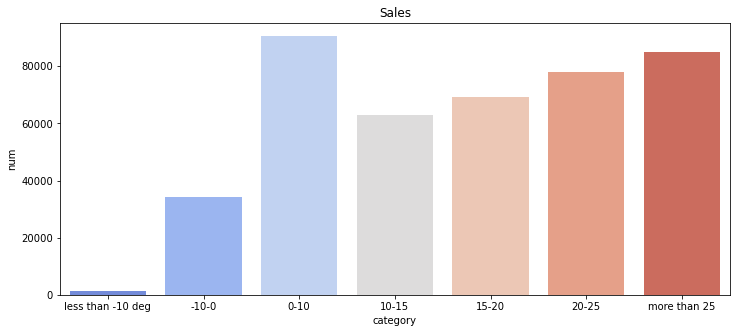

In [72]:
plt.figure(figsize = (12,5))
ax = sns.countplot(x="temperature_category", data=df, palette="coolwarm")
ax.set(xlabel="category", ylabel = "num", title="Sales")
vals = ax.get_yticks()

# The correlation of features

In [73]:
#Feature correletion analysis for store 20

In [74]:
df20=df.where( df['Store'] == 20)
df20=df20.groupby(by=['Date'], as_index=False)[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
                                                  'IsHoliday', 'Weekly_Sales']].mean()
df20 = df20.set_index('Date')
df20.head()

,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Weekly_Sales
Date,,,,,,
2010-01-10,16.155556,2.707,204.885097,7.484,0.0,27235.481831
2010-02-04,10.555556,2.850,204.025284,7.856,0.0,33878.805915
2010-02-07,21.166667,2.815,204.465056,7.527,0.0,29773.288472
2010-02-19,-3.650000,2.745,204.432100,8.187,0.0,29610.270685
2010-02-26,0.177778,2.754,204.463087,8.187,0.0,26363.804861


# correlation matrix

In [75]:
corrMatrix20 = df20.corr()

In [76]:
corrMatrix20

,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Weekly_Sales
Temperature,1.000000,0.140731,0.158361,-0.031110,-0.174949,-0.225533
Fuel_Price,0.140731,1.000000,0.800125,-0.730074,-0.066898,-0.032962
CPI,0.158361,0.800125,1.000000,-0.732422,-0.029063,0.043017
Unemployment,-0.031110,-0.730074,-0.732422,1.000000,-0.000913,-0.083594
IsHoliday,-0.174949,-0.066898,-0.029063,-0.000913,1.000000,0.122591
Weekly_Sales,-0.225533,-0.032962,0.043017,-0.083594,0.122591,1.000000


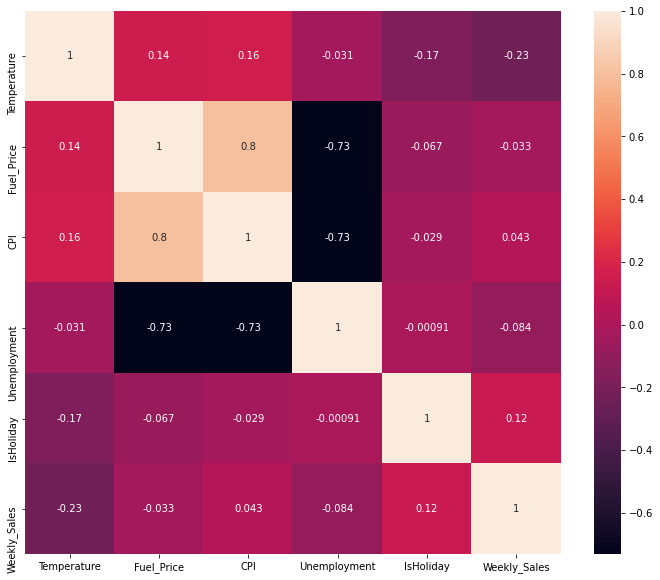

In [77]:
plt.figure(figsize=(12,10))
sns.heatmap(corrMatrix20, annot=True)
plt.show()

# 3 - Forecasting

Fbprophet without regressors

#### Out of sample overall Sales forecast with Fbprophet model

In [78]:
#Data Preparation for Fbprophet

df1=df.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()

df1 = df1.rename(columns = {'Date':'ds', 'Weekly_Sales':'y'})

In [79]:
df1.tail()

,ds,y
138,2012-10-08,47403451.04
139,2012-10-19,45122410.57
140,2012-10-26,45544116.29
141,2012-11-05,46925878.99
142,2012-12-10,46128514.25


In [80]:
# define the model
model = Prophet()
# fit the model
model.fit(df1)

In [81]:
#Range of weeks for forecast
future_dates = pd.date_range("20121216","20141230", freq='W')

In [82]:
future_dates = [pd.to_datetime(i) for i in future_dates]

In [83]:
future = pd.DataFrame([dt.datetime.strftime(i, '%Y-%m-%d') for i in future_dates],  columns=['ds'])

          ds          yhat    yhat_lower    yhat_upper
0 2012-12-16  6.147304e+07  5.623570e+07  6.646152e+07
1 2012-12-23  6.372769e+07  5.859455e+07  6.839924e+07
2 2012-12-30  5.847773e+07  5.339290e+07  6.358959e+07
3 2013-01-06  4.832863e+07  4.272913e+07  5.396550e+07
4 2013-01-13  4.051923e+07  3.535893e+07  4.588827e+07


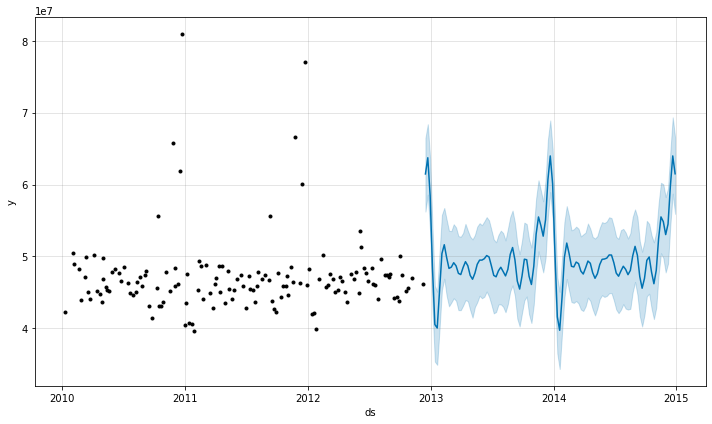

In [84]:
forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

#### In sample overall Sales forecast with Fbprophet model

In [85]:
dates = pd.date_range("20111126","20121110", freq='W')
dates = [pd.to_datetime(i) for i in dates]
dates_for_forecast = pd.DataFrame([dt.datetime.strftime(i, '%Y-%m-%d') for i in dates],  columns=['ds'])

          ds          yhat    yhat_lower    yhat_upper
0 2012-12-16  6.147304e+07  5.623570e+07  6.646152e+07
1 2012-12-23  6.372769e+07  5.859455e+07  6.839924e+07
2 2012-12-30  5.847773e+07  5.339290e+07  6.358959e+07
3 2013-01-06  4.832863e+07  4.272913e+07  5.396550e+07
4 2013-01-13  4.051923e+07  3.535893e+07  4.588827e+07


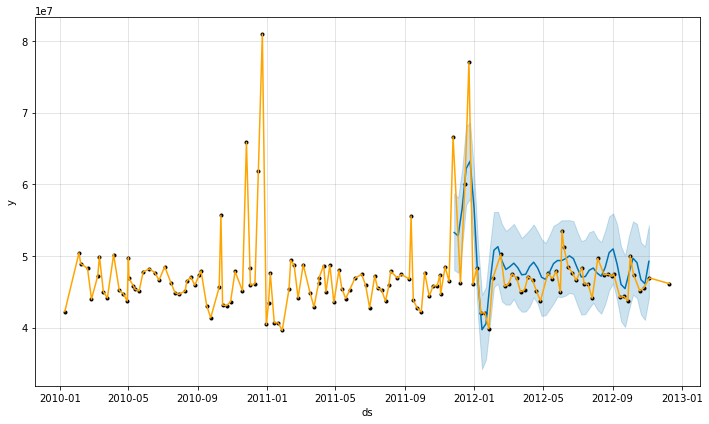

In [86]:
forecast_dates = model.predict(dates_for_forecast)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast_dates)

plt.plot(df1.ds, df1.y, color = 'orange')

plt.show()

Fbprophet with regressors

#### In sample store 20 Sales forecast with Fbprophet model

Take CPI, Temperature, IsHoliday as regressors for our model

In [87]:
df_grouped_20 = df.query('Store == 20')\
    .groupby(['Date', 'IsHoliday', 'CPI', 'Temperature'], as_index = False)\
    .agg({'Weekly_Sales':'sum'})

In [88]:
df_grouped_20.head()

,Date,IsHoliday,CPI,Temperature,Weekly_Sales
0,2010-01-10,0,204.885097,16.155556,1933719.21
1,2010-02-04,0,204.025284,10.555556,2405395.22
2,2010-02-07,0,204.465056,21.166667,2143676.77
3,2010-02-19,0,204.432100,-3.650000,2161549.76
4,2010-02-26,0,204.463087,0.177778,1898193.95


In [89]:
#Data Preparation for Fbprophet

df_grouped_20 = df_grouped_20.rename(columns = {'Date':'ds','Weekly_Sales':'y'})

In [90]:
datetime_series = pd.to_datetime(df_grouped_20['ds'])

datetime_index = pd.DatetimeIndex(datetime_series.values)

Store20_data=df_grouped_20.set_index(datetime_index)

In [91]:
Store20_data.head()

,ds,IsHoliday,CPI,Temperature,y
2010-01-10,2010-01-10,0,204.885097,16.155556,1933719.21
2010-02-04,2010-02-04,0,204.025284,10.555556,2405395.22
2010-02-07,2010-02-07,0,204.465056,21.166667,2143676.77
2010-02-19,2010-02-19,0,204.432100,-3.650000,2161549.76
2010-02-26,2010-02-26,0,204.463087,0.177778,1898193.95


In [92]:
Store20_data.shape

(143, 5)

In [93]:
train_data_pr1 = Store20_data.iloc[:len(Store20_data)-40]
test_data_pr1 = Store20_data.iloc[len(Store20_data)-40:]

In [94]:
test_data_pr2 = test_data_pr1[['ds', 'IsHoliday', 'CPI', 'Temperature']]

In [95]:
# define the model
m1 = Prophet(changepoint_prior_scale=0.05, interval_width=0.95,growth = 'linear',seasonality_mode = 'multiplicative', \
               yearly_seasonality=20, weekly_seasonality=True, changepoint_range=0.9)
m1.add_seasonality('weekly', period=7, fourier_order=15)

m1.add_regressor('IsHoliday')
m1.add_regressor('CPI')
m1.add_regressor('Temperature')
m1.fit(train_data_pr1)




           ds          yhat    yhat_lower    yhat_upper
35 2012-10-08  2.327553e+06  2.116161e+06  2.547519e+06
36 2012-10-19  2.098086e+06  1.875429e+06  2.341500e+06
37 2012-10-26  2.006343e+06  1.776091e+06  2.231391e+06
38 2012-11-05  2.251820e+06  2.021889e+06  2.494326e+06
39 2012-12-10  2.091975e+06  1.849736e+06  2.310016e+06


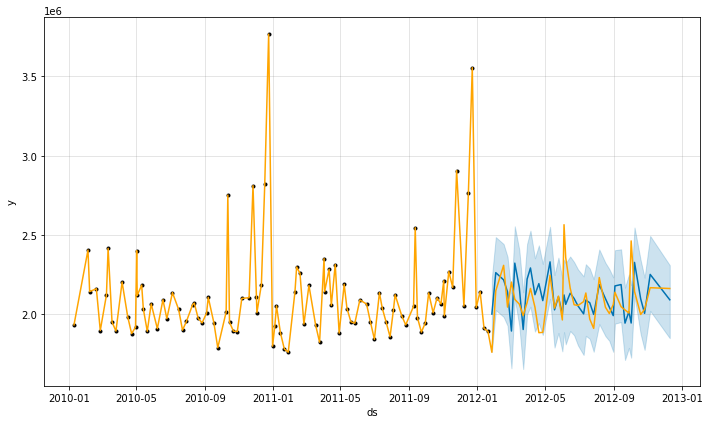

In [96]:
prophet_pred2 = m1.predict(test_data_pr2)


print(prophet_pred2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
# plot forecast
m1.plot(prophet_pred2)


plt.plot(Store20_data.ds, Store20_data.y, color = 'orange')

plt.show()

/opt/conda/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

/opt/conda/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

/opt/conda/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



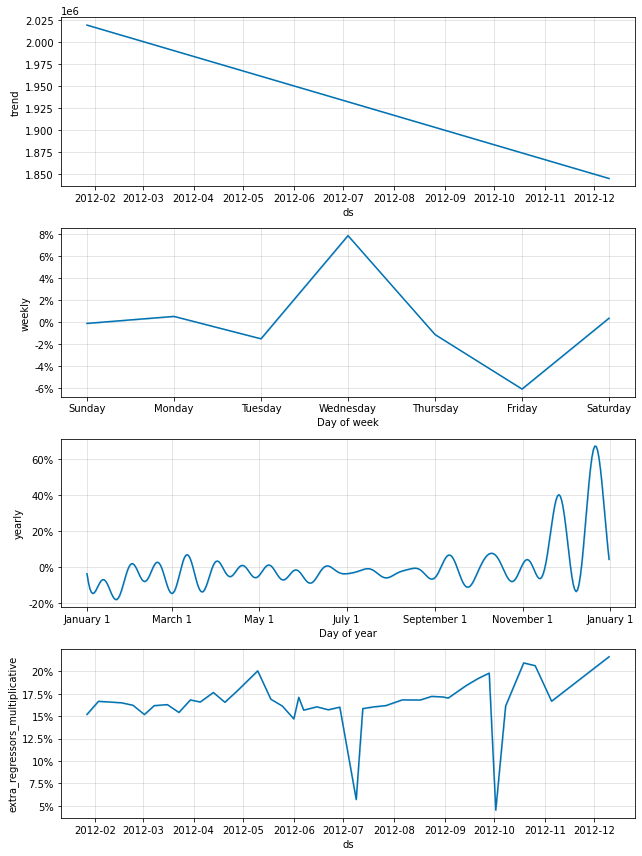

In [97]:
m1.plot_components(prophet_pred2);

In [98]:
Store20_data_2 = Store20_data[['ds', 'IsHoliday', 'CPI', 'Temperature']]

            ds          yhat    yhat_lower    yhat_upper
138 2012-10-08  2.327553e+06  2.082904e+06  2.581610e+06
139 2012-10-19  2.098086e+06  1.864801e+06  2.328666e+06
140 2012-10-26  2.006343e+06  1.776225e+06  2.245789e+06
141 2012-11-05  2.251820e+06  2.033973e+06  2.481027e+06
142 2012-12-10  2.091975e+06  1.872755e+06  2.324443e+06


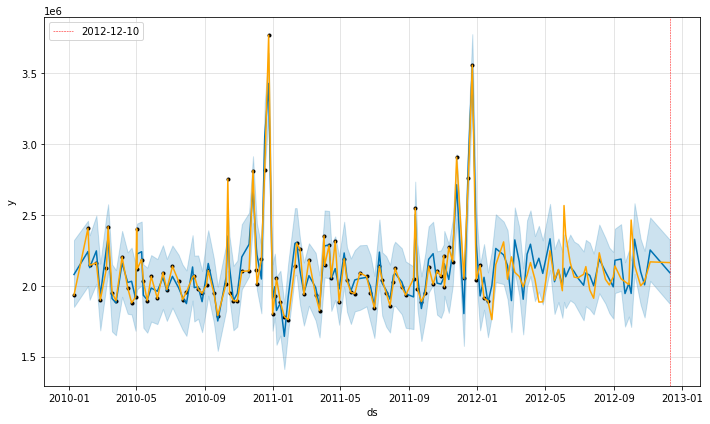

In [99]:
prophet_pred2 = m1.predict(Store20_data_2)


print(prophet_pred2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
# plot forecast
m1.plot(prophet_pred2)


plt.plot(Store20_data.ds, Store20_data.y, color = 'orange')

for x in Store20_data[Store20_data['ds']=='2012-12-10']['ds']:
    plt.axvline(x=x, color='red', linewidth=0.5, ls='--', label='2012-12-10')
    

plt.legend()

plt.show()

In [100]:
prophet_pred3 = prophet_pred2[['ds','yhat']]

In [101]:
df_ds=pd.merge(Store20_data, prophet_pred3, on=['ds'], how='left')

In [102]:
df_ds['diff'] = (df_ds['y']-df_ds['yhat'])/df_ds['y']

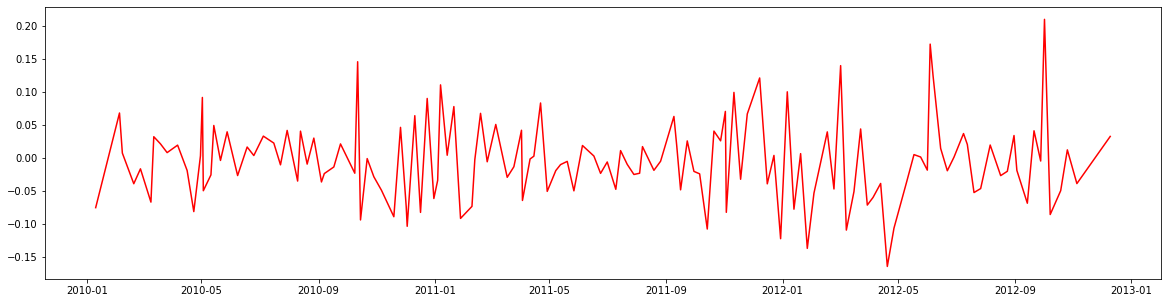

In [103]:
x1 = df_ds['ds']
y1 = df_ds['diff']
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(x1.values, y1.values, c='r')

In [104]:
df_ds[['diff']].describe()

,diff
count,143.000000
mean,-0.004346
std,0.060739
min,-0.164147
25%,-0.042571
50%,-0.005877
75%,0.028212
max,0.210173
